
# Logistic Regression for Fraud Detection (IT5022)

**Author:** MS25948592 (N.G.S.D. Nanayakkara)  
**Task:** Baseline model — Logistic Regression + threshold tuning (Recall ≥ 95%)  
**Dataset:** Kaggle — *Fraudulent Transactions Data*  


In [20]:

# ===== Imports & Configuration =====
from pathlib import Path
import os, zipfile, shutil, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, precision_recall_curve
)

warnings.filterwarnings("ignore", category=UserWarning)

# Reproducibility & plots
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True
sns.set_style("whitegrid")

# Config
QUICK_EXPERIMENT = True       # Set True to read limited rows for quicker runs
MAX_ROWS = 500_000
TRAIN_CUTOFF_STEP = 600       # time-based split on 'step'
FAST_DEV = True               # if True: lighter settings (class_weight=None, fewer iters)
LR_MAX_ITER_DEV = 200
LR_TOL_DEV = 1e-3

DATA_DIR = Path("./data"); DATA_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("./figures"); FIG_DIR.mkdir(exist_ok=True)
CSV_FILENAME = "Fraud.csv"

print("Config OK")


Config OK


In [21]:

# ===== Data Loading & Kaggle Helpers =====
def _kaggle_available():
    return shutil.which("kaggle") is not None

def _download_from_kaggle(data_dir: Path):
    print("Attempting Kaggle download…")
    rc = os.system("kaggle datasets download -d chitwanmanchanda/fraudulent-transactions-data -p data")
    if rc != 0:
        print("⚠️ Kaggle CLI returned non-zero status. Ensure it's installed & authenticated.")
        return
    for z in data_dir.glob("*.zip"):
        try:
            with zipfile.ZipFile(z, "r") as zip_ref:
                zip_ref.extractall(data_dir)
        finally:
            z.unlink(missing_ok=True)

def _find_csv_after_download(data_dir: Path) -> Path | None:
    preferred = ["Fraud.csv", "fraudTrain.csv", "PS_20174392719_1491204439457_log.csv"]
    for name in preferred:
        p = data_dir / name
        if p.exists():
            return p
    csvs = list(data_dir.glob("*.csv"))
    if not csvs:
        return None
    return max(csvs, key=lambda p: p.stat().st_size)

def read_data_pandas(path: Path, quick_experiment: bool = False, max_rows: int | None = None) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"CSV not found at: {path}")
    dtype_map = {
        "step": "int32",
        "type": "category",
        "amount": "float32",
        "nameOrig": "category",
        "oldbalanceOrg": "float32",
        "newbalanceOrig": "float32",
        "nameDest": "category",
        "oldbalanceDest": "float32",
        "newbalanceDest": "float32",
        "isFraud": "int8",
        "isFlaggedFraud": "int8",
    }
    usecols = list(dtype_map.keys())
    read_kwargs = dict(usecols=usecols, dtype=dtype_map, low_memory=False, engine="c")
    if quick_experiment and max_rows is not None:
        read_kwargs["nrows"] = int(max_rows)
    df = pd.read_csv(path, **read_kwargs)
    mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
    print(f"✅ Loaded {len(df):,} rows x {df.shape[1]} cols (~{mem_mb:.1f} MB)")
    return df

# Resolve CSV path (download if missing and Kaggle is available)
csv_path = DATA_DIR / CSV_FILENAME
if not csv_path.exists():
    print(f"CSV '{CSV_FILENAME}' not found in {DATA_DIR.resolve()}")
    if _kaggle_available():
        _download_from_kaggle(DATA_DIR)
    else:
        print("⚠️ Kaggle CLI not found. Place the dataset CSV into ./data manually.")
    resolved = _find_csv_after_download(DATA_DIR)
    if resolved is None:
        raise FileNotFoundError("No CSV found in ./data after attempting download.")
    CSV_FILENAME = resolved.name
    csv_path = resolved
    print(f"✅ Using dataset file: {csv_path.name}")
else:
    print("✅ CSV already exists:", csv_path.name)

df = read_data_pandas(csv_path, quick_experiment=QUICK_EXPERIMENT, max_rows=MAX_ROWS)
display(df.head(3))


✅ CSV already exists: Fraud.csv
✅ Loaded 500,000 rows x 11 cols (~81.4 MB)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1,0


In [22]:

# ===== Schema Validation =====
EXPECTED_COLS = {
    "step","type","amount","nameOrig","oldbalanceOrg","newbalanceOrig",
    "nameDest","oldbalanceDest","newbalanceDest","isFraud","isFlaggedFraud"
}
DTYPE_MAP = {
    "step": "int32",
    "type": "category",
    "amount": "float32",
    "nameOrig": "category",
    "oldbalanceOrg": "float32",
    "newbalanceOrig": "float32",
    "nameDest": "category",
    "oldbalanceDest": "float32",
    "newbalanceDest": "float32",
    "isFraud": "int8",
    "isFlaggedFraud": "int8",
}

def enforce_schema(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    missing = EXPECTED_COLS - set(df.columns)
    if missing:
        raise ValueError(f"❌ Missing columns: {sorted(missing)}")
    for c, t in DTYPE_MAP.items():
        if t == "category":
            df[c] = df[c].astype("category")
        else:
            df[c] = pd.to_numeric(df[c], errors="raise").astype(t)
    for bcol in ("isFraud","isFlaggedFraud"):
        uniq = set(pd.Series(df[bcol]).dropna().unique().tolist())
        if not uniq.issubset({0,1}):
            raise ValueError(f"Column '{bcol}' must be binary 0/1")
    print("✅ Schema & dtypes validated")
    return df

df = enforce_schema(df)


✅ Schema & dtypes validated


Class Distribution:
  Legitimate (0): 499,767 (99.95%)
  Fraud (1):      233 (0.0466%)


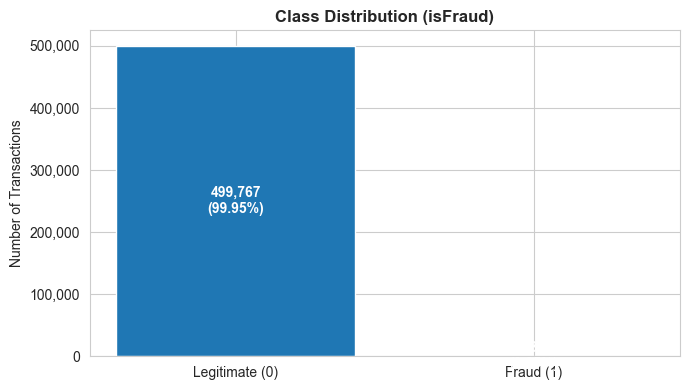

C:\Users\didula\AppData\Local\Temp\ipykernel_24264\2487248469.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_type = df.groupby('type')['isFraud'].agg(['sum','count','mean']).rename(columns={'sum':'Fraud_Count','count':'Total_Count','mean':'Fraud_Rate'})


,Fraud_Count,Total_Count,Fraud_Rate
type,,,
CASH_IN,0,109319,0.000000
CASH_OUT,121,182316,0.066368
DEBIT,0,3603,0.000000
PAYMENT,0,164032,0.000000
TRANSFER,112,40730,0.274982


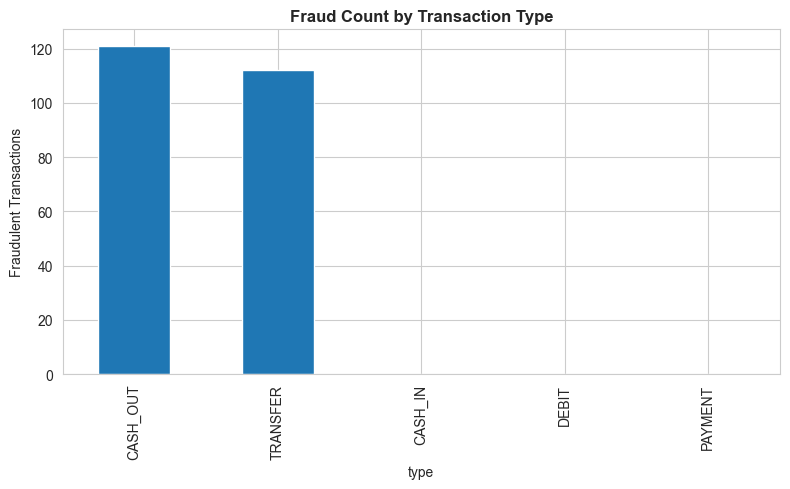

Median fraud amount: 143,032
Median legitimate amount: 81,357
% fraudulent CASH_OUT draining origin to 0: 99.17%
% fraudulent TRANSFER with unchanged destination balance: 83.93%


In [23]:

# ===== EDA (Class distribution, Fraud by type) =====
counts = df['isFraud'].value_counts().sort_index()
percentages = (counts / counts.sum()) * 100
print("Class Distribution:")
print(f"  Legitimate (0): {counts.get(0,0):,} ({percentages.get(0,float('nan')):.2f}%)")
print(f"  Fraud (1):      {counts.get(1,0):,} ({percentages.get(1,float('nan')):.4f}%)")

# Figure 1
fig, ax = plt.subplots(figsize=(7,4))
bars = ax.bar(['Legitimate (0)','Fraud (1)'], [counts.get(0,0), counts.get(1,0)])
ax.set_title("Class Distribution (isFraud)", fontweight='bold')
ax.set_ylabel("Number of Transactions")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))
for bar, count, pct in zip(bars, [counts.get(0,0), counts.get(1,0)], [percentages.get(0,0), percentages.get(1,0)]):
    ax.text(bar.get_x()+bar.get_width()/2, max(count*0.5, 1), f"{int(count):,}\n({pct:.2f}%)",
            ha='center', va='center', fontsize=10, color='white', fontweight='bold')
plt.tight_layout(); plt.savefig(FIG_DIR/'01_class_distribution.png', dpi=300, bbox_inches='tight'); plt.show()

# Fraud by type table + Figure 2
fraud_by_type = df.groupby('type')['isFraud'].agg(['sum','count','mean']).rename(columns={'sum':'Fraud_Count','count':'Total_Count','mean':'Fraud_Rate'})
fraud_by_type['Fraud_Rate'] = fraud_by_type['Fraud_Rate'] * 100.0
display(fraud_by_type)

plt.figure(figsize=(8,5))
(fraud_by_type['Fraud_Count'].sort_values(ascending=False)).plot(kind='bar')
plt.title("Fraud Count by Transaction Type", fontweight='bold')
plt.ylabel("Fraudulent Transactions")
plt.tight_layout(); plt.savefig(FIG_DIR/'02_fraud_by_type.png', dpi=300, bbox_inches='tight'); plt.show()

# Additional values for report (medians and balance observations)
median_fraud_amt = float(df.loc[df['isFraud']==1, 'amount'].median())
median_legit_amt = float(df.loc[df['isFraud']==0, 'amount'].median())

# "Drain" definition: origin balance becomes exactly zero after tx
cashout = df[(df['type']=="CASH_OUT") & (df['isFraud']==1)]
pct_drain_cashout = float((cashout['newbalanceOrig']==0).mean()*100) if len(cashout)>0 else float('nan')

# "Leave dest unchanged" definition: oldbalanceDest == newbalanceDest with amount>0
transfer = df[(df['type']=="TRANSFER") & (df['isFraud']==1)]
pct_transfer_nochange_dest = float(((transfer['oldbalanceDest']==transfer['newbalanceDest']) & (transfer['amount']>0)).mean()*100) if len(transfer)>0 else float('nan')

print(f"Median fraud amount: {median_fraud_amt:,.0f}")
print(f"Median legitimate amount: {median_legit_amt:,.0f}")
print(f"% fraudulent CASH_OUT draining origin to 0: {pct_drain_cashout:.2f}%")
print(f"% fraudulent TRANSFER with unchanged destination balance: {pct_transfer_nochange_dest:.2f}%")


In [24]:

# ===== Feature Engineering =====
def add_engineered_features(df: pd.DataFrame):
    df = df.copy()
    for c in ["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]:
        df[c] = df[c].astype("float32")
    df["tx_delta_orig"] = (df["oldbalanceOrg"] - df["newbalanceOrig"] - df["amount"]).astype("float32")
    df["tx_delta_dest"] = (df["newbalanceDest"] - df["oldbalanceDest"]).astype("float32")
    denom_orig = df["oldbalanceOrg"]; denom_dest = df["oldbalanceDest"]; num = df["amount"]
    df["orig_balance_ratio"] = np.divide(num, denom_orig, out=np.zeros_like(num, dtype="float32"), where=(denom_orig>0)).astype("float32")
    df["dest_balance_ratio"] = np.divide(num, denom_dest, out=np.zeros_like(num, dtype="float32"), where=(denom_dest>0)).astype("float32")
    df["flag_orig_negative"] = (df["newbalanceOrig"] < 0).astype("int8")
    df["flag_dest_negative"] = (df["newbalanceDest"] < 0).astype("int8")
    df["flag_orig_nochange"] = ((df["oldbalanceOrg"]==df["newbalanceOrig"]) & (df["amount"]>0)).astype("int8")
    df["flag_dest_nochange"] = ((df["oldbalanceDest"]==df["newbalanceDest"]) & (df["amount"]>0)).astype("int8")
    df["flag_high_risk_type"] = df["type"].isin(["CASH_OUT","TRANSFER"]).astype("int8")
    df["log_amount"] = np.log1p(df["amount"]).astype("float32")
    df["origZeroBalanceAfter"] = (df["newbalanceOrig"]==0).astype("int8")
    df["destZeroBalanceBefore"] = (df["oldbalanceDest"]==0).astype("int8")
    df["hourOfDay"] = (df["step"] % 24).astype("int8")
    df["dayOfMonth"] = (df["step"] // 24).astype("int16")
    df.drop(columns=["nameOrig","nameDest"], inplace=True, errors="ignore")
    num_cols = df.select_dtypes(include=["float32","float64"]).columns
    if not np.isfinite(df[num_cols].to_numpy()).all():
        df.replace([np.inf,-np.inf], np.nan, inplace=True)
    if df[num_cols].isna().any().any():
        df[num_cols] = df[num_cols].fillna(0.0)

    numeric_feats = ["step","amount",
        "oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest",
        "tx_delta_orig","tx_delta_dest","orig_balance_ratio","dest_balance_ratio",
        "flag_orig_negative","flag_dest_negative","flag_orig_nochange","flag_dest_nochange",
        "flag_high_risk_type","log_amount","origZeroBalanceAfter","destZeroBalanceBefore",
        "hourOfDay","dayOfMonth"]
    categorical_feats = ["type"]
    df["type"] = df["type"].astype("string")
    return df, numeric_feats, categorical_feats

df, numeric_feats, categorical_feats = add_engineered_features(df)
print("Feature engineering complete. Total cols:", df.shape[1])


Feature engineering complete. Total cols: 23


In [25]:

# ===== Time-aware Train/Test Split (safe) =====
def time_aware_split(df: pd.DataFrame, cutoff: int, target_col: str = "isFraud", verbose: bool = True):
    work = df.copy()
    work["step"] = pd.to_numeric(work["step"], errors="raise")
    train_mask = work["step"] <= cutoff
    test_mask = work["step"] > cutoff
    df_train = work.loc[train_mask].copy().sort_values("step").reset_index(drop=True)
    df_test = work.loc[test_mask].copy().sort_values("step").reset_index(drop=True)

    if (df_train.empty or df_test.empty):
        # fallback cutoff at 80th percentile of step
        fallback = int(work["step"].quantile(0.8))
        print(f"⚠️ Adjusting cutoff from {cutoff} to {fallback} to avoid empty split.")
        train_mask = work["step"] <= fallback
        test_mask = work["step"] > fallback
        df_train = work.loc[train_mask].copy().sort_values("step").reset_index(drop=True)
        df_test = work.loc[test_mask].copy().sort_values("step").reset_index(drop=True)
        cutoff = fallback

    if verbose:
        def _rng(d):
            return (int(d["step"].min()), int(d["step"].max())) if not d.empty else (np.nan, np.nan)
        tr_rng = _rng(df_train); te_rng = _rng(df_test)
        tr_pos = int(df_train[target_col].sum()); te_pos = int(df_test[target_col].sum())
        tr_rate = float(df_train[target_col].mean()); te_rate = float(df_test[target_col].mean())
        print(f"Train: {df_train.shape} | steps [{tr_rng[0]}, {tr_rng[1]}] | fraud: {tr_pos:,} ({tr_rate:.4%})")
        print(f"Test:  {df_test.shape} | steps [{te_rng[0]}, {te_rng[1]}] | fraud: {te_pos:,} ({te_rate:.4%})")
    return df_train, df_test, cutoff

df_train, df_test, USED_CUTOFF = time_aware_split(df, cutoff=TRAIN_CUTOFF_STEP)

feature_cols = numeric_feats + categorical_feats
X_train = df_train[feature_cols].copy(); y_train = df_train["isFraud"].astype("int8").values
X_test  = df_test[feature_cols].copy();  y_test  = df_test["isFraud"].astype("int8").values

for c in categorical_feats:
    X_train[c] = X_train[c].astype("string")
    X_test[c]  = X_test[c].astype("string")

print("Shapes -> X_train:", X_train.shape, "| X_test:", X_test.shape)


⚠️ Adjusting cutoff from 600 to 18 to avoid empty split.
Train: (441131, 23) | steps [1, 18] | fraud: 220 (0.0499%)
Test:  (58869, 23) | steps [19, 20] | fraud: 13 (0.0221%)
Shapes -> X_train: (441131, 21) | X_test: (58869, 21)


In [26]:

# ===== Preprocess & Train Logistic Regression =====
def create_preprocess(numeric_feats, categorical_feats):
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True, dtype=np.float32)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True, dtype=np.float32)
    preprocess = ColumnTransformer(
        transformers=[
            ("num", MaxAbsScaler(), numeric_feats),
            ("cat", ohe, categorical_feats),
        ],
        remainder="drop", sparse_threshold=1.0, verbose_feature_names_out=False
    )
    return preprocess

preprocess = create_preprocess(numeric_feats, categorical_feats)
LR_CLASS_WEIGHT = None if FAST_DEV else "balanced"

lr_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        solver="sag",
        class_weight=LR_CLASS_WEIGHT,
        max_iter=LR_MAX_ITER_DEV if FAST_DEV else 1000,
        tol=LR_TOL_DEV if FAST_DEV else 1e-4,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    ))
])

print("Training Logistic Regression…")
lr_pipe.fit(X_train, y_train)
print("✅ LR training complete.")


Training Logistic Regression…


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


max_iter reached after 91 seconds
✅ LR training complete.


In [27]:

# ===== Threshold tuning & Metrics =====
def threshold_table(y_true, y_scores, sort_by="f1", descending=True, beta=1.0, min_precision=None, min_recall=None, grid_points=101):
    EPS = 1e-12
    y_true = np.asarray(y_true).astype(int).ravel()
    y_scores = np.asarray(y_scores, dtype=float).ravel()
    qs = np.linspace(0.0, 1.0, grid_points)
    thresholds = np.quantile(y_scores, qs)
    thresholds = np.unique(np.clip(thresholds, 0.0, 1.0))
    rows = []
    for t in thresholds:
        y_pred = (y_scores >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
        precision = tp / (tp + fp + EPS)
        recall = tp / (tp + fn + EPS)
        f1 = 2*precision*recall / (precision + recall + EPS)
        b2 = beta*beta
        fbeta = (1+b2) * (precision*recall) / (b2*precision + recall + EPS)
        rows.append({"threshold": float(t), "precision": precision, "recall": recall, "f1": f1, "fbeta": fbeta,
                     "tp": int(tp), "fp": int(fp), "fn": int(fn), "tn": int(tn)})
    df_thr = pd.DataFrame(rows)
    mask = pd.Series(True, index=df_thr.index)
    if min_precision is not None: mask &= df_thr["precision"] >= float(min_precision)
    if min_recall is not None:    mask &= df_thr["recall"] >= float(min_recall)
    filtered = df_thr.loc[mask].copy() if mask.any() else df_thr
    filtered = filtered.sort_values(sort_by, ascending=not descending).reset_index(drop=True)
    best_row = filtered.iloc[0].copy()
    return filtered, best_row

proba_lr = lr_pipe.predict_proba(X_test)[:, 1]
roc_auc_lr = roc_auc_score(y_test, proba_lr)
pr_auc_lr  = average_precision_score(y_test, proba_lr)
print(f"Default-threshold PR/ROC AUC → PR-AUC={pr_auc_lr:.4f}, ROC-AUC={roc_auc_lr:.4f}")

tbl_lr, best_lr = threshold_table(y_test, proba_lr, sort_by="precision", min_recall=0.95, beta=2.0)
CHOSEN_THRESHOLD_LR = float(best_lr["threshold"])
pred_lr = (proba_lr >= CHOSEN_THRESHOLD_LR).astype(int)

tn_lr, fp_lr, fn_lr, tp_lr = confusion_matrix(y_test, pred_lr).ravel()
precision_lr = precision_score(y_test, pred_lr, zero_division=0)
recall_lr    = recall_score(y_test, pred_lr, zero_division=0)
f1_lr        = f1_score(y_test, pred_lr, zero_division=0)

print(f"Chosen threshold τ = {CHOSEN_THRESHOLD_LR:.4f}")
print(f"Precision: {precision_lr:.4f}\nRecall: {recall_lr:.4f}\nF1: {f1_lr:.4f}\nROC-AUC: {roc_auc_lr:.4f}\nPR-AUC: {pr_auc_lr:.4f}")
print(f"TN={tn_lr:,}, FP={fp_lr:,}, FN={fn_lr:,}, TP={tp_lr:,}")

# Derived report numbers
fp_rate = (fp_lr / (fp_lr + tn_lr) * 100.0) if (fp_lr + tn_lr) > 0 else np.nan
n_alerts = int(tp_lr + fp_lr)
alert_rate = (n_alerts / len(y_test) * 100.0) if len(y_test)>0 else np.nan
print(f"False Positive Rate: {fp_lr} / {fp_lr + tn_lr} = {fp_rate:.4f}%")
print(f"Alerts generated: {n_alerts} of {len(y_test):,} = {alert_rate:.2f}%")


Default-threshold PR/ROC AUC → PR-AUC=0.5365, ROC-AUC=0.9657
Chosen threshold τ = 0.0000
Precision: 0.0010
Recall: 1.0000
F1: 0.0019
ROC-AUC: 0.9657
PR-AUC: 0.5365
TN=45,329, FP=13,527, FN=0, TP=13
False Positive Rate: 13527 / 58856 = 22.9832%
Alerts generated: 13540 of 58,869 = 23.00%


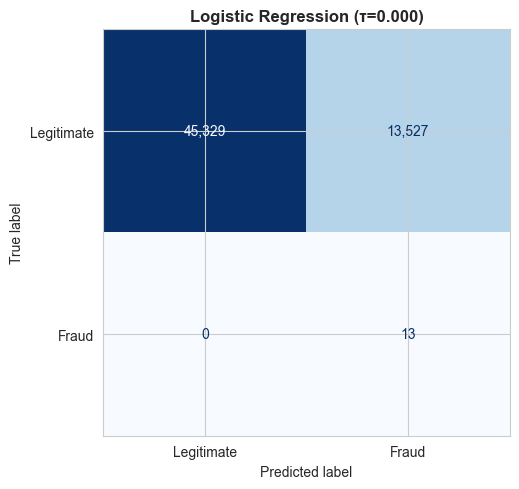

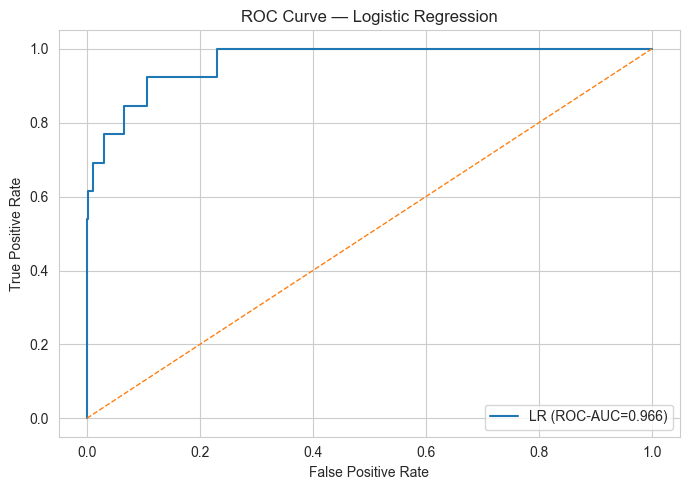

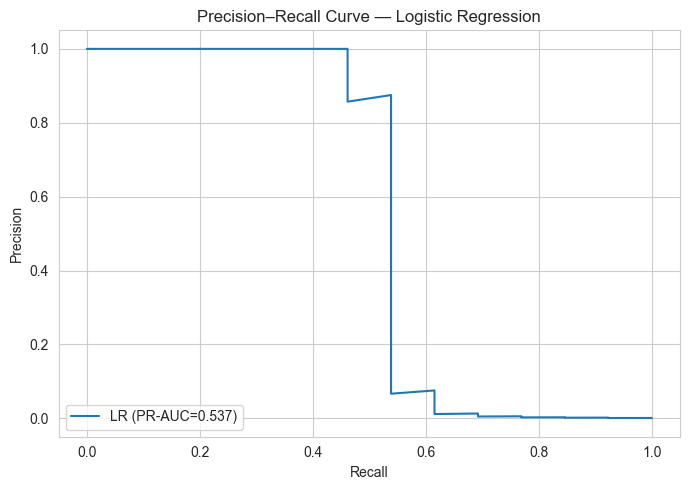

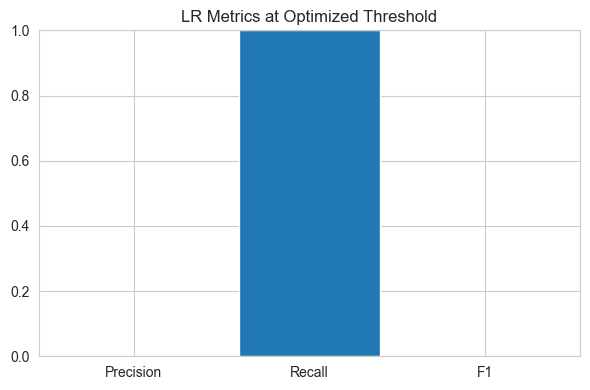

In [28]:

# ===== Visualizations (saved to ./figures) =====

# Confusion matrix
fig, ax = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay.from_predictions(y_test, pred_lr, display_labels=["Legitimate","Fraud"], values_format=",.0f", colorbar=False, cmap='Blues', ax=ax)
ax.set_title(f'Logistic Regression (τ={CHOSEN_THRESHOLD_LR:.3f})', fontweight='bold')
plt.tight_layout(); plt.savefig(FIG_DIR/'03_lr_confusion_matrix.png', dpi=300, bbox_inches='tight'); plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, proba_lr)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'LR (ROC-AUC={roc_auc_lr:.3f})')
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve — Logistic Regression')
plt.legend(loc='lower right'); plt.tight_layout(); plt.savefig(FIG_DIR/'07_roc_curves_lr.png', dpi=300, bbox_inches='tight'); plt.show()

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test, proba_lr)
plt.figure(figsize=(7,5))
plt.plot(rec, prec, label=f'LR (PR-AUC={pr_auc_lr:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall Curve — Logistic Regression')
plt.legend(loc='lower left'); plt.tight_layout(); plt.savefig(FIG_DIR/'08_pr_curves_lr.png', dpi=300, bbox_inches='tight'); plt.show()

# Bar chart of precision/recall/F1
plt.figure(figsize=(6,4))
plt.bar(['Precision','Recall','F1'], [precision_lr, recall_lr, f1_lr])
plt.ylim(0,1); plt.title('LR Metrics at Optimized Threshold'); plt.tight_layout()
plt.savefig(FIG_DIR/'09_metrics_comparison_bar.png', dpi=300, bbox_inches='tight'); plt.show()


In [29]:

# ===== Save results_for_report.txt =====
results_text = f"""LR Results (optimized threshold)
---------------------------------
Threshold (τ): {CHOSEN_THRESHOLD_LR:.6f}

Precision: {precision_lr:.6f}
Recall: {recall_lr:.6f}
F1-Score: {f1_lr:.6f}
ROC-AUC: {roc_auc_lr:.6f}
PR-AUC: {pr_auc_lr:.6f}

Confusion Matrix:
TN: {tn_lr:,}
FP: {fp_lr:,}
FN: {fn_lr:,}
TP: {tp_lr:,}

False Positive Rate: {fp_lr} / {fp_lr + tn_lr} = {fp_rate:.6f}%
Alerts generated: {n_alerts} of {len(y_test):,} = {alert_rate:.6f}%

Medians & Observations for EDA:
Median fraud amount: {median_fraud_amt:,.0f}
Median legitimate amount: {median_legit_amt:,.0f}
% fraudulent CASH_OUT draining origin to 0: {pct_drain_cashout:.2f}%
% fraudulent TRANSFER with unchanged destination balance: {pct_transfer_nochange_dest:.2f}%
"""

with open("results_for_report.txt","w", encoding="utf-8") as f:
    f.write(results_text)

print(results_text)


LR Results (optimized threshold)
---------------------------------
Threshold (τ): 0.000041

Precision: 0.000960
Recall: 1.000000
F1-Score: 0.001918
ROC-AUC: 0.965661
PR-AUC: 0.536517

Confusion Matrix:
TN: 45,329
FP: 13,527
FN: 0
TP: 13

False Positive Rate: 13527 / 58856 = 22.983213%
Alerts generated: 13540 of 58,869 = 23.000221%

Medians & Observations for EDA:
Median fraud amount: 143,032
Median legitimate amount: 81,357
% fraudulent CASH_OUT draining origin to 0: 99.17%
% fraudulent TRANSFER with unchanged destination balance: 83.93%




### Files generated
- `figures/01_class_distribution.png`
- `figures/02_fraud_by_type.png`
- `figures/03_lr_confusion_matrix.png`
- `figures/07_roc_curves_lr.png`
- `figures/08_pr_curves_lr.png`
- `figures/09_metrics_comparison_bar.png`
- `results_for_report.txt`
